In [1]:
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import zipfile
from datetime import datetime
from shutil import copyfile
import seaborn as sns

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
Path = Path('data/actors')

In [4]:
# Path.ls()

In [5]:
# zip_ref = zipfile.ZipFile(Path/'train.zip', 'r')
# zip_ref.extractall(Path)
# zip_ref.close()

In [6]:
# for idx in range(0,len(train_labels)):
#     copyfile(f"{path}/images/{train_labels.loc[idx,'image']}", f"{path}/train_images/{train_labels.loc[idx,'image']}")

In [7]:
# for idx in range(0,len(test_labels)):
#     copyfile(f"{path}/images/{test_labels.loc[idx,'image']}", f"{path}/test_images/{test_labels.loc[idx,'image']}")

In [8]:
train_df = pd.read_csv(f"{Path}/train.csv")
train_df.shape

(19906, 2)

In [9]:
test_df = pd.read_csv(Path/'test.csv')
test_df.shape

(6636, 1)

In [10]:
submission = pd.read_csv(Path/'sample_submission.csv')
submission.shape

(0, 2)

In [11]:
filepath, dirs, files = next(os.walk(f"{Path}/Train"))
len(files)

19906

In [12]:
filepath, dirs, files = next(os.walk(f"{Path}/Test"))
len(files)

6636

In [13]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [14]:
test_df.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [15]:
train_df.groupby('Class').count()

,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


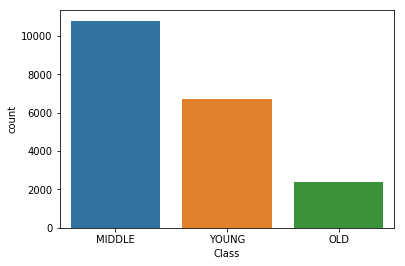

In [16]:
sns.countplot(x='Class' , data=train_df)

In [17]:
test_set = ImageList.from_df(test_df, path=Path, folder='Test')

In [18]:
trfm = get_transforms(max_zoom=1.22, max_lighting=0.22, max_warp=0.0)

In [19]:
np.random.seed(2019)
src = (ImageList.from_df(train_df, path=Path, folder='Train')
       .split_by_rand_pct(0.1)
       .label_from_df()
       .add_test(test_set)
      )

In [20]:
data = (src.transform(trfm, size=128, padding_mode='reflection', resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
        )

In [21]:
data.classes

['MIDDLE', 'OLD', 'YOUNG']

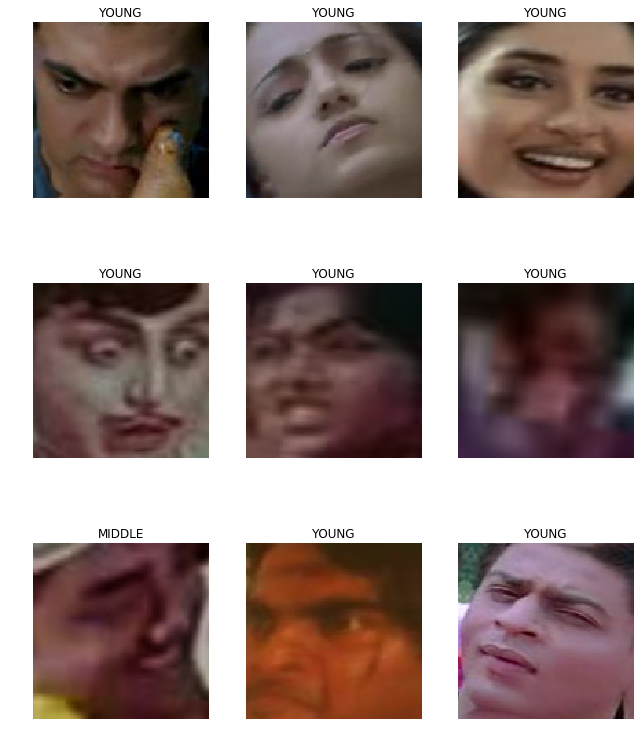

In [22]:
data.show_batch(rows=3, figsize=(9,11))

In [23]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['MIDDLE', 'OLD', 'YOUNG'], 3, 17916, 1990)

In [24]:
model_name = 'efficientnet-b3'
def getModel(pret):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features,data.c)
    return model

In [25]:
learn = Learner(data
                ,getModel(True)
                ,metrics=[error_rate, accuracy]
                ,callback_fns = ShowGraph
               )

Loaded pretrained weights for efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


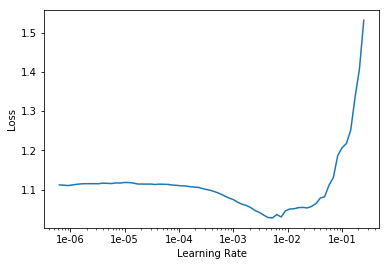

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 0.001

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.709205,0.660881,0.267337,0.732663,02:15
1,0.499266,0.514802,0.185427,0.814573,02:14
2,0.405782,0.548135,0.183417,0.816583,02:14
3,0.354316,0.605546,0.254774,0.745226,02:15
4,0.283650,0.548946,0.228141,0.771859,02:15
5,0.214587,0.491143,0.173869,0.826131,02:14
6,0.142824,0.288224,0.102010,0.897990,02:15
7,0.081263,0.234060,0.079899,0.920101,02:14
8,0.046891,0.227523,0.066332,0.933668,02:15
9,0.029413,0.231811,0.068844,0.931156,02:15


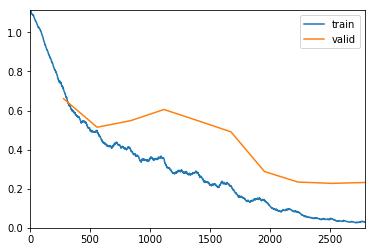

In [28]:
learn.fit_one_cycle(10, slice(1e-3), wd=0.2)

In [29]:
learn.save('stage-1-128-enb3')

fine tuning the whole model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-06


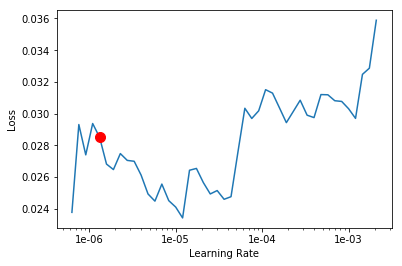

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.028755,0.231404,0.068844,0.931156,02:14
1,0.026712,0.232518,0.068844,0.931156,02:15
2,0.025552,0.232481,0.069347,0.930653,02:15
3,0.029163,0.232406,0.069849,0.930151,02:15
4,0.025135,0.234895,0.067839,0.932161,02:15
5,0.024157,0.235305,0.068342,0.931658,02:15
6,0.022558,0.235985,0.068342,0.931658,02:15
7,0.026241,0.235961,0.068342,0.931658,02:15
8,0.022622,0.235987,0.069347,0.930653,02:15
9,0.020617,0.236924,0.067337,0.932663,02:15


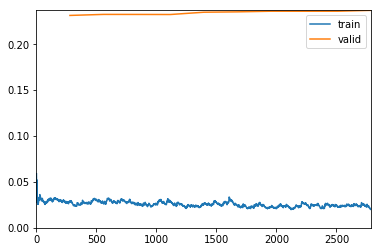

In [32]:
learn.fit_one_cycle(10, slice(5e-06),wd=0.15) #0.909045

In [33]:
learn.save('stage-2-128-enb3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 5.75E-05


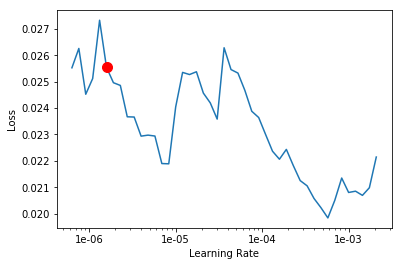

In [36]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.025012,0.241253,0.066332,0.933668,02:15
1,0.025393,0.256081,0.069347,0.930653,02:15
2,0.028228,0.268521,0.075879,0.924121,02:15
3,0.022551,0.300366,0.074874,0.925126,02:15
4,0.019716,0.286758,0.070352,0.929648,02:15
5,0.016020,0.304950,0.067839,0.932161,02:15
6,0.015854,0.278187,0.068342,0.931658,02:15
7,0.011629,0.281014,0.068844,0.931156,02:15
8,0.011302,0.280567,0.066332,0.933668,02:15
9,0.012172,0.279528,0.066332,0.933668,02:15


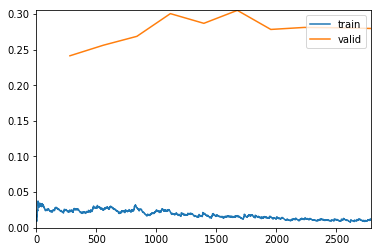

In [37]:
learn.fit_one_cycle(10, slice(1e-4), wd=0.1)

In [38]:
learn.save('stage-3-128-enb3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


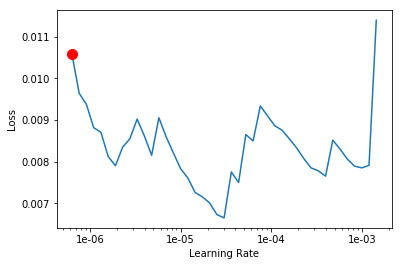

In [39]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.012085,0.282735,0.064322,0.935678,02:15
1,0.010201,0.283638,0.069849,0.930151,02:15
2,0.007998,0.283029,0.066834,0.933166,02:15
3,0.009710,0.286382,0.066834,0.933166,02:15
4,0.009474,0.284534,0.066834,0.933166,02:15


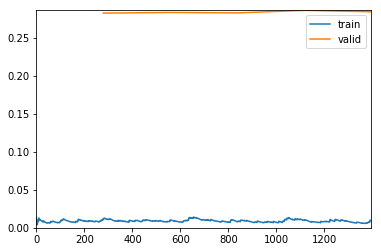

In [40]:
learn.fit_one_cycle(5, slice(1e-5), wd=0.1)

In [41]:
learn.save('stage-4-128-enb3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


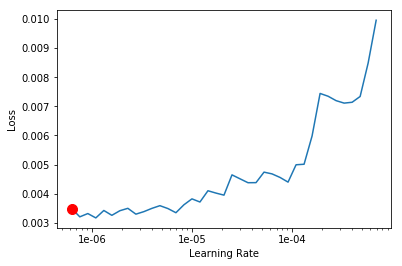

In [44]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.010125,0.283579,0.068342,0.931658,02:15
1,0.009024,0.283908,0.067839,0.932161,02:15
2,0.010804,0.283997,0.067337,0.932663,02:15
3,0.007636,0.284724,0.067337,0.932663,02:15
4,0.008331,0.282758,0.066834,0.933166,02:15


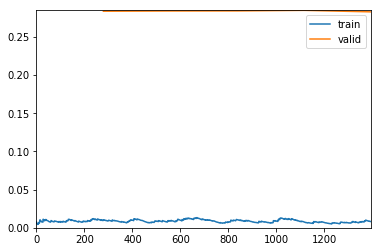

In [45]:
learn.fit_one_cycle(5, slice(7e-7), wd=0.1)

In [46]:
learn.save('stage-5-128-enb3')

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

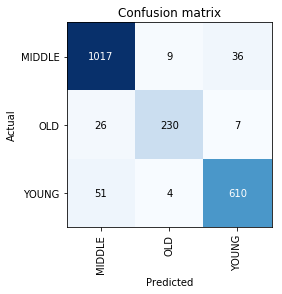

In [48]:
interp.plot_confusion_matrix()

In [49]:
interp.most_confused(min_val=2)

[('YOUNG', 'MIDDLE', 51),
 ('MIDDLE', 'YOUNG', 36),
 ('OLD', 'MIDDLE', 26),
 ('MIDDLE', 'OLD', 9),
 ('OLD', 'YOUNG', 7),
 ('YOUNG', 'OLD', 4)]

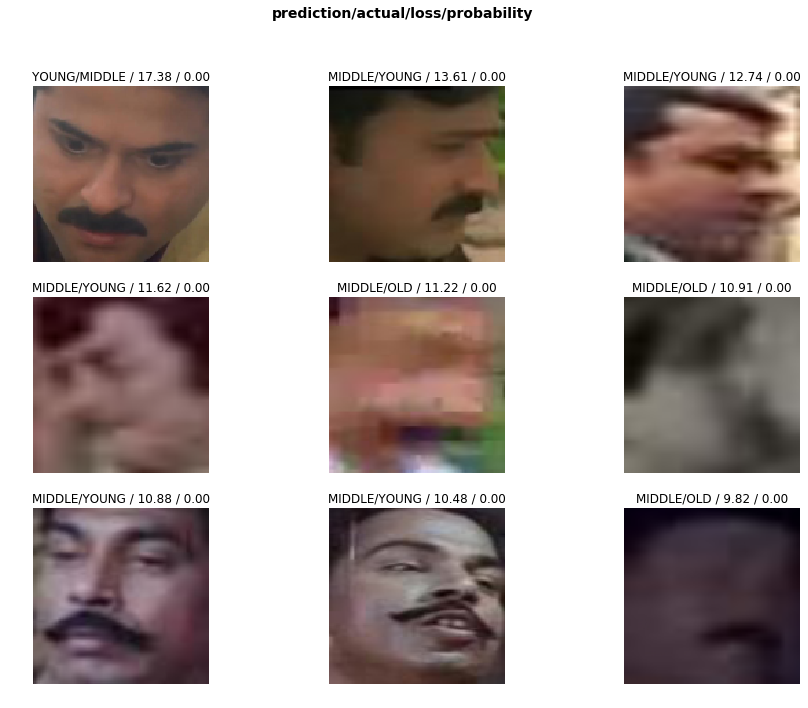

In [50]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

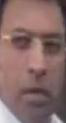

In [51]:
img = open_image(Path/'Test/19277.jpg')
img

In [52]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category MIDDLE, tensor(0), tensor([9.9757e-01, 6.4459e-04, 1.7828e-03]))

In [53]:
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y)

0.9311557788944723

In [54]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [55]:
preds

tensor([[9.7127e-01, 2.4188e-02, 4.5389e-03],
        [1.5697e-04, 3.2503e-04, 9.9952e-01],
        [7.3860e-01, 1.4297e-03, 2.5997e-01],
        ...,
        [9.9906e-01, 9.1030e-04, 2.4684e-05],
        [9.9976e-01, 2.3537e-04, 6.9189e-07],
        [1.4586e-02, 2.0721e-01, 7.7820e-01]])

In [57]:
final = [data.classes[i] for i in np.argmax(preds, axis=1)]

In [58]:
final[:5]

['MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'MIDDLE']

In [59]:
submission['Class'] = final
submission['ID'] = test_df['ID']

In [60]:
submission.head(10)

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
5,MIDDLE,19851.jpg
6,YOUNG,10384.jpg
7,YOUNG,24567.jpg
8,MIDDLE,2029.jpg
9,MIDDLE,4956.jpg


In [61]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{Path}/Submission_enb3_{file_timestamp}.csv', index=False)